In [2]:
import os, errno
import argparse
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from scipy.stats import kurtosis
from scipy.stats.mstats import moment
from scipy import stats
from scipy.stats import ttest_ind, f_oneway

from util.load_data_basic import *

# date_time format
date_time_format = '%Y-%m-%dT%H:%M:%S.%f'
date_only_date_time_format = '%Y-%m-%d'

# sleep after work duration thereshold
sleep_after_work_duration_threshold = 12
sleep_after_sleep_duration_threshold = 2

# data folder
main_data_directory = '../data/keck_wave1/2_preprocessed_data'
recording_timeline_directory = '../output/recording_timeline'
sleep_timeline_directory = '../output/sleep_timeline'
individual_timeline_directory = 'output/individual_timeline'



## Read Basic Information

In [101]:
# Read sleep data for all participant
SleepDataDf = pd.read_csv(os.path.join('output', 'sleep_survey_full.csv'))

# Read ID
IDs = getParticipantID(main_data_directory, index=False)

# Read MGT
MGT = read_MGT(main_data_directory)

# Read Pre-Study info
PreStudyInfo = read_pre_study_info(main_data_directory)

# Read IGTB info
IGTB = read_IGTB(main_data_directory)

# Day shift data
day_data = SleepDataDf.loc[SleepDataDf['shift_type'] == 1]
day_workday_data = day_data.loc[(day_data['is_sleep_before_work'] == 1) & (day_data['is_sleep_after_work'] == 1)]
day_off_day_data = day_data.loc[(day_data['is_sleep_before_work'] != 1) & (day_data['is_sleep_after_work'] != 1)]
day_transition_day_data = day_data.loc[(day_data['is_sleep_transition_before_work'] == 1) | (day_data['is_sleep_transition_after_work'] == 1)]

# Night shift data
night_data = SleepDataDf.loc[SleepDataDf['shift_type'] == 2]
night_workday_data = night_data.loc[(night_data['is_sleep_before_work'] == 1) & (night_data['is_sleep_after_work'] == 1)]
night_off_day_data = night_data.loc[(night_data['is_sleep_before_work'] != 1) & (night_data['is_sleep_after_work'] != 1)]
night_transition_day_data = night_data.loc[(night_data['is_sleep_transition_before_work'] == 1) | (night_data['is_sleep_transition_after_work'] == 1)]

# Data array
data_array = [day_data, night_data, 
              day_workday_data, day_off_day_data, 
              night_workday_data, night_off_day_data]

data_type = ['day-shift all', 'night-shift all',
             'day-shift workday', 'day-shift off day', 
             'night-shift workday', 'night-shift off day']

colunm_type = ['duration_in_seconds', 'SleepEfficiency',
               'SleepMinutesStageDeep', 'SleepMinutesStageLight', 'SleepMinutesStageRem',
               'sleep_heart_rate_mean', 'sleep_heart_rate_std',
               'sleep_heart_rate_percentile_10', 'sleep_heart_rate_percentile_90']

UserInfo = pd.merge(IGTB, PreStudyInfo, left_on='uid', right_on='uid', how='outer')
UserInfo = pd.merge(UserInfo, IDs, left_on='uid', right_on='uid', how='outer')
UserInfo = UserInfo.set_index('uid')


## Plot IGTB

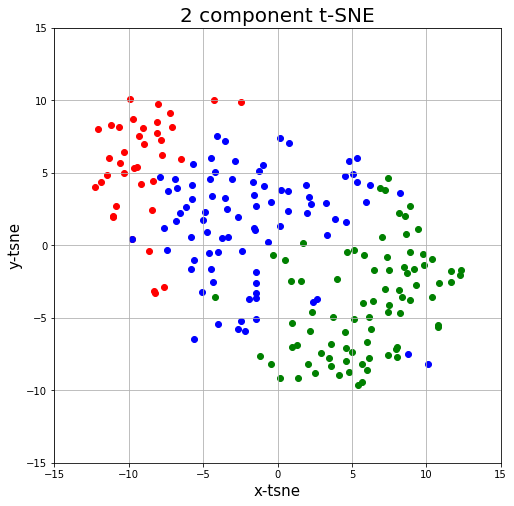

In [141]:
from sklearn.mixture import GMM
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import time
from ggplot import *

colors = ['r', 'g', 'b']

select_column = ['participant_id', 'shift_pre-study', 
                 'life_satisfaction_pre-study', 'wellbeing_pre-study',
                 'social_functioning_pre-study', 'pain_pre-study', 'general_health_pre-study',
                 'neu_igtb', 'con_igtb', 'ext_igtb', 'agr_igtb', 'ope_igtb']

select_data_df = UserInfo[select_column].dropna()

# Ground truth
ground_truth = select_data_df[['participant_id', 'shift_pre-study', 
                               'life_satisfaction_pre-study', 'wellbeing_pre-study',
                               'social_functioning_pre-study', 'pain_pre-study', 'general_health_pre-study']]

big_five = select_data_df[['neu_igtb', 'con_igtb', 'ext_igtb', 'agr_igtb', 'ope_igtb']]

# GMM
# gmm = GaussianMixture(n_components=3, covariance_type='full', max_iter=300).fit(big_five)
gmm = GaussianMixture(n_components=3, max_iter=300).fit(big_five)
labels = gmm.predict(big_five)

bigFiveLabelDf = pd.DataFrame(data=labels, columns=['big_five_label'], index=select_data_df.index)
finalDf = pd.concat([big_five, bigFiveLabelDf], axis=1)
finalDf = pd.concat([finalDf, ground_truth], axis=1)


# t-SNE
tsne = TSNE(n_components=2, random_state=0, n_iter=500)
tsne_results = tsne.fit_transform(big_five)

finalDf = finalDf.loc[:,:].copy()
finalDf['x-tsne'] = tsne_results[:,0]
finalDf['y-tsne'] = tsne_results[:,1]

# Plot t-SNE
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
ax.set_xlabel('x-tsne', fontsize = 15)
ax.set_ylabel('y-tsne', fontsize = 15)
ax.set_title('2 component t-SNE', fontsize = 20)

for label, color in zip(range(3), colors):
    data_to_plot = finalDf.loc[finalDf['big_five_label'] == label]
    ax.scatter(data_to_plot['x-tsne'], data_to_plot['y-tsne'], c = color)
    
ax.set_xlim([-15, 15])
ax.set_ylim([-15, 15])

ax.grid()
plt.show()


## IGTB Big five and other

In [160]:
select_col = ['life_satisfaction_pre-study', 'wellbeing_pre-study',
              'social_functioning_pre-study', 'pain_pre-study', 
              'general_health_pre-study']

shift_type = ['day', 'night']

sleep_col = ['SleepMinutesAwake', 'SleepMinutesStageDeep', 'SleepMinutesStageLight', 'SleepMinutesStageRem',
             'SleepMinutesStageWake', 'SleepEfficiency', 'duration_in_seconds',
             'sleep_heart_rate_max', 'sleep_heart_rate_min', 'sleep_heart_rate_mean', 'sleep_heart_rate_std',
             'sleep_heart_rate_percentile_10', 'sleep_heart_rate_percentile_90', 'sleep_heart_rate_kurtosis']

for col in sleep_col:
    
    print('%s\n' % (col))
    # get sleep data for each group
    for shift in range(1, 3, 1):
        # shift_sleep = SleepDataDf.loc[SleepDataDf['shift_type'] == shift]
        work_day_sleep = SleepDataDf.loc[(SleepDataDf['is_sleep_before_work'] == 1) | (SleepDataDf['is_sleep_after_work'] == 1)]
        shift_sleep = work_day_sleep.loc[work_day_sleep['shift_type'] == shift]

        ANOVA_array = []
        for i in range(3):
            participant_group_array = finalDf.loc[(finalDf['big_five_label'] == i)]['participant_id'].values

            sleep_data_df = pd.DataFrame()
            for participant_id in participant_group_array:
                frame = shift_sleep.loc[(shift_sleep['participant_id'] == participant_id)]
                sleep_data_df = sleep_data_df.append(frame)

            ANOVA_array.append(sleep_data_df[col].dropna())

            print('%s Shift, big_five_label: %d' % (shift_type[shift-1], i))
            # print('Mean = %.3f, STD = %.3f' % (np.mean(sleep_data_df['duration_in_seconds'].dropna() / 3600), 
            #                                   np.std(sleep_data_df['duration_in_seconds'].dropna() / 3600)))

            print('Mean = %.3f, STD = %.3f' % (np.mean(sleep_data_df[col].dropna()), 
                                               np.std(sleep_data_df[col].dropna())))

        stat, p = f_oneway(ANOVA_array[0], ANOVA_array[1], ANOVA_array[2])

        # print('\n')
        print('ANOVA Test')
        print('Statistics = %.3f, p = %.3f \n' % (stat, p))
        print('\n')

# IGTB Construct
for col in select_col:
    for i in range(3):
        select_df = finalDf.loc[(finalDf['big_five_label'] == i)][col]
        
        print('IGTB Type: %s, big_five_label: %d' % (col, i))
        print('Mean = %.3f, STD = %.3f' % (np.mean(select_df), np.std(select_df)))
    
    print('\n')
    
    stat, p = f_oneway(finalDf.loc[(finalDf['big_five_label'] == 0)][col], 
                       finalDf.loc[(finalDf['big_five_label'] == 1)][col], 
                       finalDf.loc[(finalDf['big_five_label'] == 2)][col])
        
    print('ANOVA Test')
    print('Statistics = %.3f, p = %.3f \n' % (stat, p))

    print('\n')




SleepMinutesAwake

day Shift, big_five_label: 0
Mean = 45.208, STD = 21.268
day Shift, big_five_label: 1
Mean = 49.415, STD = 21.756
day Shift, big_five_label: 2
Mean = 48.085, STD = 21.859
ANOVA Test
Statistics = 7.131, p = 0.001 



night Shift, big_five_label: 0
Mean = 43.387, STD = 29.014
night Shift, big_five_label: 1
Mean = 36.056, STD = 24.242
night Shift, big_five_label: 2
Mean = 38.384, STD = 27.458
ANOVA Test
Statistics = 6.500, p = 0.002 



SleepMinutesStageDeep

day Shift, big_five_label: 0
Mean = 59.583, STD = 24.366
day Shift, big_five_label: 1
Mean = 65.676, STD = 25.876
day Shift, big_five_label: 2
Mean = 62.022, STD = 25.727
ANOVA Test
Statistics = 10.347, p = 0.000 



night Shift, big_five_label: 0
Mean = 54.913, STD = 25.584
night Shift, big_five_label: 1
Mean = 58.872, STD = 29.487
night Shift, big_five_label: 2
Mean = 53.362, STD = 28.383
ANOVA Test
Statistics = 3.256, p = 0.039 



SleepMinutesStageLight

day Shift, big_five_label: 0
Mean = 217.756, STD = 63.237